This notebook contains the winning solution to the VSB Power Line Fault Detection competition.

Key Information:

    * Simple LightGBM model
    * Standard 5-fold CV
    * Uses just 9 features
    * Features all calculated using the peaks in the signals
    * Run times:
        * Generating features: ~15 minutes
        * Training: ~2 minutes
        * Prediction: ~10 seconds

In [1]:
# Set RECALCULATE_PEAK_FEATURES to True to recalculate the per peak features
RECALCULATE_PEAK_FEATURES = True
# The PREPROCESSED_DIR is used to load the previous commit's per peak features if 
# RECALCULATE_PEAK_FEATURES is set to False. Note, if the kernel is forked this 
# variable needs to be updated to point to the forked kernel's directory
PREPROCESSED_DIR = '../input/vsb-1st-place-solution'

In [2]:
USE_SIMPLIFIED_VERSION = False

In [3]:
if RECALCULATE_PEAK_FEATURES:
    # If performing preprocessing to calculate the per peak features need a newer version of
    # numba than the latest kaggle docker image
    !conda update -y numba

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

In [4]:
import copy
import gc
import os
import sys
import warnings

from IPython.core.display import display, HTML
import lightgbm as lgb
from matplotlib import pyplot as plt
import numba
import numpy as np
import pandas as pd
import pyarrow
import pyarrow.parquet as pq
import scipy.stats
import seaborn as sns 
import sklearn
from sklearn.metrics import matthews_corrcoef, precision_recall_fscore_support

In [5]:
data_dir = '../input/vsb-power-line-fault-detection'

In [6]:
for p in [scipy, np, numba, sklearn, lgb, pyarrow, pd]:
    print('{}=={}'.format(p.__name__, p.__version__))
    
print()

print(sys.version)

# Tested using versions:
#scipy==1.1.0
#numpy==1.16.2
#numba==0.43.0
#sklearn==0.20.3
#lightgbm==2.2.3
#pyarrow==0.10.0
#pandas==0.23.4

scipy==1.1.0
numpy==1.16.2
numba==0.43.0
sklearn==0.20.3
lightgbm==2.2.3
pyarrow==0.10.0
pandas==0.23.4

3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]


In [7]:
meta_train_df = pd.read_csv(data_dir + '/metadata_train.csv')
meta_test_df = pd.read_csv(data_dir + '/metadata_test.csv')

In [8]:
meta_train_df.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


# Functions

In [9]:
@numba.jit(nopython=True)
def flatiron(x, alpha=100., beta=1):
    """
    Flatten signal
    
    Creator: Michael Kazachok
    Source: https://www.kaggle.com/miklgr500/flatiron
    """
    new_x = np.zeros_like(x)
    zero = x[0]
    for i in range(1, len(x)):
        zero = zero*(alpha-beta)/alpha + beta*x[i]/alpha
        new_x[i] = x[i] - zero
    return new_x

In [10]:
@numba.jit(nopython=True)
def drop_missing(intersect,sample):
    """
    Find intersection of sorted numpy arrays
    
    Since intersect1d sort arrays each time, it's effectively inefficient.
    Here you have to sweep intersection and each sample together to build
    the new intersection, which can be done in linear time, maintaining order. 

    Source: https://stackoverflow.com/questions/46572308/intersection-of-sorted-numpy-arrays
    Creator: B. M.
    """
    i=j=k=0
    new_intersect=np.empty_like(intersect)
    while i< intersect.size and j < sample.size:
        if intersect[i]==sample[j]: # the 99% case
            new_intersect[k]=intersect[i]
            k+=1
            i+=1
            j+=1
        elif intersect[i]<sample[j]:
            i+=1
        else : 
            j+=1
    return new_intersect[:k]

In [11]:
@numba.jit(nopython=True)
def _local_maxima_1d_window_single_pass(x, w):
    
    midpoints = np.empty(x.shape[0] // 2, dtype=np.intp)
    left_edges = np.empty(x.shape[0] // 2, dtype=np.intp)
    right_edges = np.empty(x.shape[0] // 2, dtype=np.intp)
    m = 0  # Pointer to the end of valid area in allocated arrays

    i = 1  # Pointer to current sample, first one can't be maxima
    i_max = x.shape[0] - 1  # Last sample can't be maxima
    while i < i_max:
        # Test if previous sample is smaller
        if x[i - 1] < x[i]:
            i_ahead = i + 1  # Index to look ahead of current sample

            # Find next sample that is unequal to x[i]
            while i_ahead < i_max and x[i_ahead] == x[i]:
                i_ahead += 1
                    
            i_right = i_ahead - 1
            
            f = False
            i_window_end = i_right + w
            while i_ahead < i_max and i_ahead < i_window_end:
                if x[i_ahead] > x[i]:
                    f = True
                    break
                i_ahead += 1
                
            # Maxima is found if next unequal sample is smaller than x[i]
            if x[i_ahead] < x[i]:
                left_edges[m] = i
                right_edges[m] = i_right
                midpoints[m] = (left_edges[m] + right_edges[m]) // 2
                m += 1
                
            # Skip samples that can't be maximum
            i = i_ahead - 1
        i += 1

    # Keep only valid part of array memory.
    midpoints = midpoints[:m]
    left_edges = left_edges[:m]
    right_edges = right_edges[:m]
    
    return midpoints, left_edges, right_edges

@numba.jit(nopython=True)
def local_maxima_1d_window(x, w=1):
    """
    Find local maxima in a 1D array.
    This function finds all local maxima in a 1D array and returns the indices
    for their midpoints (rounded down for even plateau sizes).
    It is a modified version of scipy.signal._peak_finding_utils._local_maxima_1d
    to include the use of a window to define how many points on each side to use in
    the test for a point being a local maxima.
    Parameters
    ----------
    x : ndarray
        The array to search for local maxima.
    w : np.int
        How many points on each side to use for the comparison to be True
    Returns
    -------
    midpoints : ndarray
        Indices of midpoints of local maxima in `x`.
    Notes
    -----
    - Compared to `argrelmax` this function is significantly faster and can
      detect maxima that are more than one sample wide. However this comes at
      the cost of being only applicable to 1D arrays.
    """    
        
    fm, fl, fr = _local_maxima_1d_window_single_pass(x, w)
    bm, bl, br = _local_maxima_1d_window_single_pass(x[::-1], w)
    bm = np.abs(bm - x.shape[0] + 1)[::-1]
    bl = np.abs(bl - x.shape[0] + 1)[::-1]
    br = np.abs(br - x.shape[0] + 1)[::-1]

    m = drop_missing(fm, bm)

    return m

In [12]:
@numba.jit(nopython=True)
def plateau_detection(grad, threshold, plateau_length=5):
    """Detect the point when the gradient has reach a plateau"""
    
    count = 0
    loc = 0
    for i in range(grad.shape[0]):
        if grad[i] > threshold:
            count += 1
        
        if count == plateau_length:
            loc = i - plateau_length
            break
            
    return loc

In [13]:
#@numba.jit(nopython=True)
def get_peaks(
    x, 
    window=25,
    visualise=False,
    visualise_color=None,
):
    """
    Find the peaks in a signal trace.
    Parameters
    ----------
    x : ndarray
        The array to search.
    window : np.int
        How many points on each side to use for the local maxima test
    Returns
    -------
    peaks_x : ndarray
        Indices of midpoints of peaks in `x`.
    peaks_y : ndarray
        Absolute heights of peaks in `x`.
    x_hp : ndarray
        An absolute flattened version of `x`.
    """
    
    x_hp = flatiron(x, 100, 1)

    x_dn = np.abs(x_hp)
    
    peaks = local_maxima_1d_window(x_dn, window)
    
    heights = x_dn[peaks]
    
    ii = np.argsort(heights)[::-1]
    
    peaks = peaks[ii]
    heights = heights[ii]
    
    ky = heights
    kx = np.arange(1, heights.shape[0]+1)
    
    conv_length = 9

    grad = np.diff(ky, 1)/np.diff(kx, 1)
    grad = np.convolve(grad, np.ones(conv_length)/conv_length)#, mode='valid')
    grad = grad[conv_length-1:-conv_length+1]
    
    knee_x = plateau_detection(grad, -0.01, plateau_length=1000)
    knee_x -= conv_length//2
    
    if visualise:
        plt.plot(grad, color=visualise_color)
        plt.axvline(knee_x, ls="--", color=visualise_color)
    
    peaks_x = peaks[:knee_x]
    peaks_y = heights[:knee_x]
    
    ii = np.argsort(peaks_x)
    peaks_x = peaks_x[ii]
    peaks_y = peaks_y[ii]
        
    return peaks_x, peaks_y, x_hp

In [14]:
@numba.jit(nopython=True)
def clip(v, l, u):
    """Numba helper function to clip a value"""
    
    if v < l:
        v = l
    elif v > u:
        v = u
        
    return v

In [15]:
peak_features_names = [
    'ratio_next',
    'ratio_prev',
    'small_dist_to_min',
    'sawtooth_rmse',
]

num_peak_features = len(peak_features_names)

@numba.jit(nopython=True)
def create_sawtooth_template(sawtooth_length, pre_length, post_length):
    """Generate sawtooth template"""
    
    l = pre_length+post_length+1
    
    st = np.zeros(l)
    for i in range(sawtooth_length+1):
        
        j = pre_length+i
        if j < l:
            st[j] = 1 - ((2./sawtooth_length) * i)
        
    return st

@numba.jit(nopython=True)
def calculate_peak_features(px, x_hp0, ws=5, wl=25):
    """
    Calculate features for peaks.
    Parameters
    ----------
    px : ndarray
        Indices of peaks.
    x_hp0 : ndarray
        The array to search.
    ws : np.int
        How many points on each side to use for small window features
    wl : np.int
        How many points on each side to use for large window features
    Returns
    -------
    features : ndarray
        Features calculate for each peak in `x_hp0`.
    """
    
    features = np.ones((px.shape[0], num_peak_features), dtype=np.float64) * np.nan
    
    for i in range(px.shape[0]):
        
        feature_number = 0
        
        x = px[i]
        x_next = x+1
        x_prev = x-1
        
        h0 = x_hp0[x]

        ws_s = clip(x-ws, 0, 800000-1)
        ws_e = clip(x+ws, 0, 800000-1)
        wl_s = clip(x-wl, 0, 800000-1)
        wl_e = clip(x+wl, 0, 800000-1)
        
        ws_pre = x - ws_s
        ws_post = ws_e - x
        
        wl_pre = x - wl_s
        wl_post = wl_e - x
        
        if x_next < 800000:
            h0_next = x_hp0[x_next]
            features[i, feature_number] = np.abs(h0_next)/np.abs(h0)
        feature_number += 1
            
        if x_prev >= 0:
            h0_prev = x_hp0[x_prev]
            features[i, feature_number] = np.abs(h0_prev)/np.abs(h0)
        feature_number += 1
            
        x_hp_ws0 = x_hp0[ws_s:ws_e+1]
        x_hp_wl0 = x_hp0[wl_s:wl_e+1]
        x_hp_wl0_norm = (x_hp_wl0/np.abs(h0))
        x_hp_ws0_norm = (x_hp_ws0/np.abs(h0))
        x_hp_abs_wl0 = np.abs(x_hp_wl0)
        wl_max_0 = np.max(x_hp_abs_wl0)
        
        ws_opp_peak_i = np.argmin(x_hp_ws0*np.sign(h0))
        
        features[i, feature_number] = ws_opp_peak_i - ws
        feature_number += 1
        
        x_hp_wl0_norm_sign = x_hp_wl0_norm * np.sign(h0)
        
        sawtooth_length = 3
        st = create_sawtooth_template(sawtooth_length, wl_pre, wl_post)
        assert np.argmax(st) == np.argmax(x_hp_wl0_norm_sign)
        assert st.shape[0] == x_hp_wl0_norm_sign.shape[0]
        features[i, feature_number] = np.mean(np.power(x_hp_wl0_norm_sign - st, 2))
        feature_number += 1
        
        if i == 0:
            assert feature_number == num_peak_features
        
    return features

In [16]:
def process_signal(
    data,
    window=25,
):
    """
    Process a signal trace to find the peaks and calculate features for each peak.
    Parameters
    ----------
    data : ndarray
        The array to search.
    window : np.int
        How many points on each side to use for the local maxima test
    Returns
    -------
    px0 : ndarray
        Indices for each peak in `data`.
    height0 : ndarray
        Absolute heaight for each peak in `data`.
    f0 : ndarray
        Features calculate for each peak in `data`.
    """
    
    px0, height0, x_hp0 = get_peaks(
        data.astype(np.float),
        window=window, 
    )
            
    f0 = calculate_peak_features(px0, x_hp0)
    
    return px0, height0, f0

In [17]:
def process_measurement_peaks(data, signal_ids):
    """
    Process three signal traces in measurment to find the peaks
    and calculate features for each peak.
    Parameters
    ----------
    data : ndarray
        Signal traces.
    signal_ids : ndarray
        Signal IDs for each of the signal traces in measurment
    Returns
    -------
    res : ndarray
        Data for each peak in the three traces in `data`.
    sigid_res : ndarray
        Signal ID for each row in `res`.
    """
    res = []
    sigid_res = []
    
    assert data.shape[1] % 3 == 0
    N = data.shape[1]//3
    
    for i in range(N):
        
        sigids = signal_ids[i*3:(i+1)*3]
        x = data[:, i*3:(i+1)*3].astype(np.float)
        
        px0, height0, f0 = process_signal(
            x[:, 0]
        )
        
        px1, height1, f1 = process_signal(
            x[:, 1]
        )
        
        px2, height2, f2 = process_signal(
            x[:, 2]
        )
        
        if px0.shape[0] != 0:
            res.append(np.hstack([
                px0[:, np.newaxis], 
                height0[:, np.newaxis],
                f0,
            ]))
            
            sigid_res.append(np.ones(px0.shape[0], dtype=np.int) * sigids[0])
        
        if px1.shape[0] != 0:
            res.append(np.hstack([
                px1[:, np.newaxis], 
                height1[:, np.newaxis],
                f1,
            ]))

            sigid_res.append(np.ones(px1.shape[0], dtype=np.int) * sigids[1])
        
        if px2.shape[0] != 0:
            res.append(np.hstack([
                px2[:, np.newaxis], 
                height2[:, np.newaxis],
                f2,
            ]))

            sigid_res.append(np.ones(px2.shape[0], dtype=np.int) * sigids[2])
            
    return res, sigid_res

In [18]:
def process_measurement(data_df, meta_df, fft_data):
    """
    Process three signal traces in measurment to find the peaks
    and calculate features for each peak.
    Parameters
    ----------
    data_df : pandas.DataFrame
        Signal traces.
    meta_df : pandas.DataFrame
        Meta data for measurement
    fft_data : ndarray
        50Hz fourier coefficient for three traces
    Returns
    -------
    peaks : pandas.DataFrame
        Data for each peak in the three traces in `data`.
    """
    peaks, sigids = process_measurement_peaks(
        data_df.values, # [:, :100*3], 
        meta_df['signal_id'].values, # [:100*3]
    )
    
    peaks = np.concatenate(peaks)

    peaks = pd.DataFrame(
        peaks,
        columns=['px', 'height'] + peak_features_names
    )
    peaks['signal_id'] = np.concatenate(sigids)

    # Calculate the phase resolved location of each peak

    phase_50hz = np.angle(fft_data, deg=False) # fft_data[:, 1]

    phase_50hz = pd.DataFrame(
        phase_50hz,
        columns=['phase_50hz']
    )
    phase_50hz['signal_id'] = meta_df['signal_id'].values

    peaks = pd.merge(peaks, phase_50hz, on='signal_id', how='left')

    dt = (20e-3/(800000))
    f1 = 50
    w1 = 2*np.pi*f1
    peaks['phase_aligned_x'] = (np.degrees(
        (w1*peaks['px'].values*dt) + peaks['phase_50hz'].values
    ) + 90) % 360
    
    # Calculate the phase resolved quarter for each peak
    peaks['Q'] = pd.cut(peaks['phase_aligned_x'], [0, 90, 180, 270, 360], labels=[0, 1, 2, 3])
    
    return peaks

In [19]:
@numba.jit(nopython=True, parallel=True)
def calculate_50hz_fourier_coefficient(data):
    """Calculate the 50Hz Fourier coefficient of a signal.
    Assumes the signal is 800000 data points long and covering 20ms.
    """

    n = 800000
    assert data.shape[0] == n
    
    omegas = np.exp(-2j * np.pi * np.arange(n) / n).reshape(n, 1)
    m_ = omegas ** np.arange(1, 2)
    
    m = m_.flatten()

    res = np.zeros(data.shape[1], dtype=m.dtype)
    for i in numba.prange(data.shape[1]):
        res[i] = m.dot(data[:, i].astype(m.dtype))
            
    return res

# Preprocessing Overview

Each signal trace is preprocessed to identify the peaks and calculate features.

The steps performed to do this are:

    1. Flatten the trace using the flatiron function
    2. Identify the local maxima peaks in each trace using the local_maxima_1d_window function
    3. Filter the peaks identified in step 2 to separate the signal from the noise
    4. Calculate features for each peak identified in step 3 using calculate_peak_features

Step 2. To identify the local maxima the function local_maxima_1d_window is used. This function takes a window length argument, which is the number of points on each side to use for the comparison. An example of the behaviour of this function can be seen below:

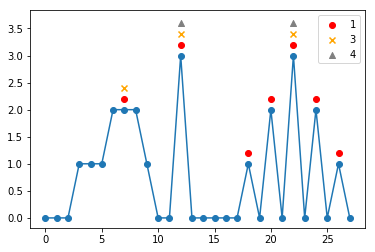

In [20]:
a = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0])

p1 = local_maxima_1d_window(a, w=1)
p3 = local_maxima_1d_window(a, w=3)
p4 = local_maxima_1d_window(a, w=4)

plt.plot(a, marker='o')
plt.scatter(p1, a[p1]+0.2, color='red', label='1')
plt.scatter(p3, a[p3]+0.4, color='orange', marker='x', label='3')
plt.scatter(p4, a[p4]+0.6, color='grey', marker='^', label='4')
plt.legend()
plt.show()

Step 3. Once all the peaks in a trace have been identified, the peaks caused by the noise in the signal need to be removed. This is performed in the get_peaks function. When the peaks are ordered by height, knee detection is performed to identify the point when the height of the peaks stops changing due to the noise floor being reached. The steps are:
    
    1. Order the peaks by their height
    2. Calculate the gradient between each consecutive pair of peaks
    3. Smooth the gradients using a convolution operation
    4. Find the noise floor using the plateau_detection function
    
The location of the threshold identified for a number of signals can be seen below:

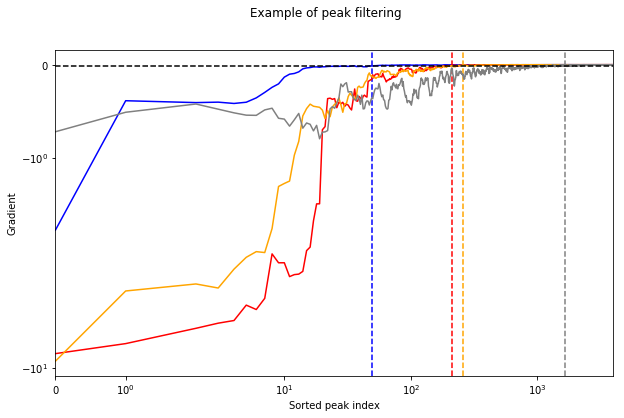

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sigids = [2323, 10, 4200, 4225]
colours = ['blue', 'red', 'orange', 'grey']
for i, sigid in enumerate(sigids):
    d = pq.read_pandas(
        data_dir + '/train.parquet',
        columns=[str(sigid)]
    ).to_pandas().values[:, 0].astype(np.float)
    get_peaks(d, visualise=True, visualise_color=colours[i])

plt.xlim([0, 4000])
plt.axhline(-0.01, color='black', ls='--')
plt.yscale("symlog")
plt.xscale("symlog")

plt.xlabel('Sorted peak index')
plt.ylabel('Gradient')
plt.suptitle('Example of peak filtering')

plt.show()

Some examples of the peaks detected using the steps outlined above can be seen below:

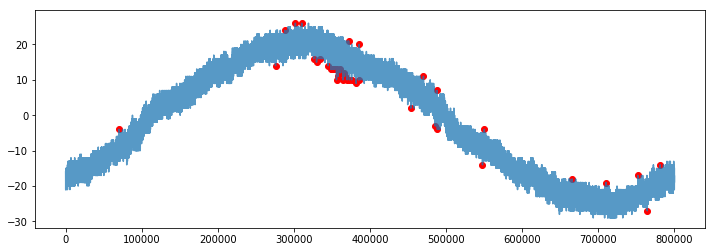

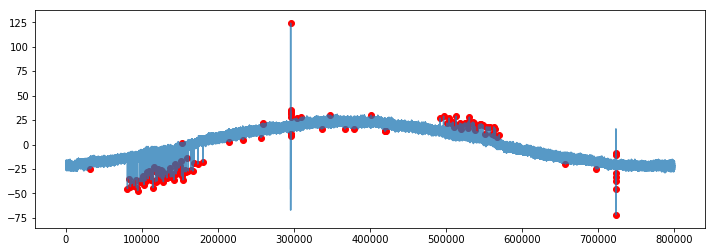

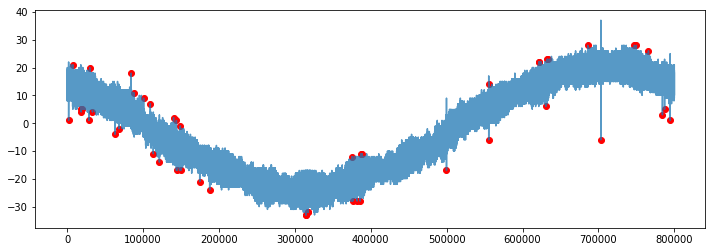

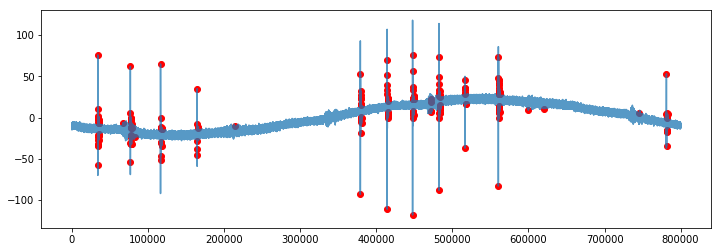

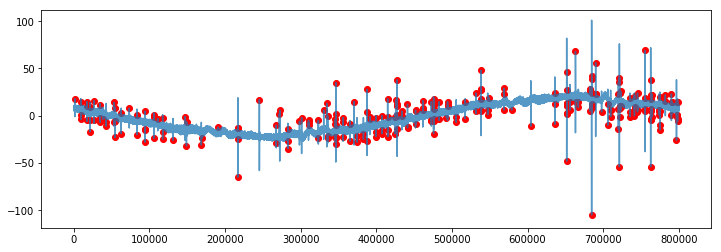

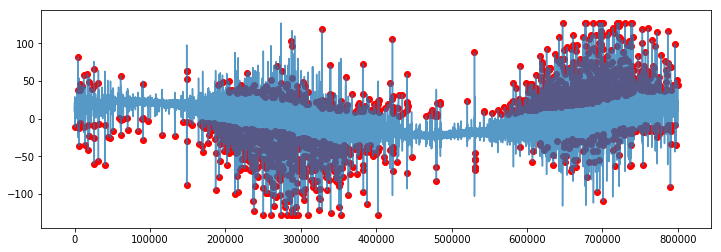

In [22]:
sigids = [100, 230, 2323, 10, 4200, 4225]

for sigid in sigids:
    d = pq.read_pandas(
        data_dir + '/train.parquet',
        columns=[str(sigid)]
    ).to_pandas().values[:, 0].astype(np.float)

    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    plt.plot(d, alpha=0.75)

    px, py, _ = get_peaks(d)
    
    plt.scatter(px, d[px], color="red")
    plt.show()

Step 4. Once the noisy peaks have been removed, features are calcuated for each of the remaining peaks. This is performed in calculate_peak_features. Of the features the most interesting is the sawtooth_rmse feature. This is the RMSE between the window of values including the peak and 25 data points either side of the peak and a sawtooth like template. An example of this can be seen below:

In [23]:
def plot_sawtooth_example(measid, px, w):
    
    display(HTML(meta_train_df[meta_train_df['id_measurement'] == measid].to_html()))
    
    sigids = [measid * 3 + i for i in range(3)]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))

    for i, sigid in enumerate(sigids):
        d = pq.read_pandas(
            data_dir + '/train.parquet',
            columns=[str(sigid)]
        ).to_pandas().values[:, 0].astype(np.float)

        d = flatiron(d)
        d = d[px-w:px+w+1]
        plt.plot(d, marker='o', label='{}) {}'.format(i, sigid))

        if i == 1:
            s = d[w]
            ft = create_sawtooth_template(3, w, w) * s
            plt.plot(ft, color='black', ls='--')

    plt.axvline(w, color='black', ls='--')
    plt.legend()
    plt.show()

,signal_id,id_measurement,phase,target
2115,2115,705,0,1
2116,2116,705,1,1
2117,2117,705,2,1


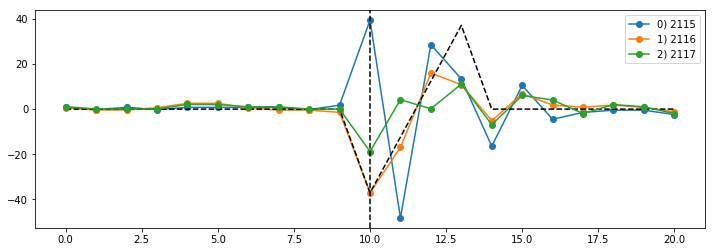

In [24]:
measid = 705
px = 520128 # 93911 # 123144
w = 10

plot_sawtooth_example(measid, px, w)

,signal_id,id_measurement,phase,target
3273,3273,1091,0,0
3274,3274,1091,1,0
3275,3275,1091,2,1


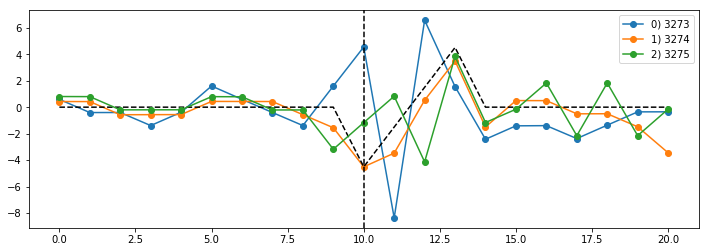

In [25]:
measid = 1091
px = 593144
w = 10

plot_sawtooth_example(measid, px, w)

,signal_id,id_measurement,phase,target
8280,8280,2760,0,1
8281,8281,2760,1,1
8282,8282,2760,2,0


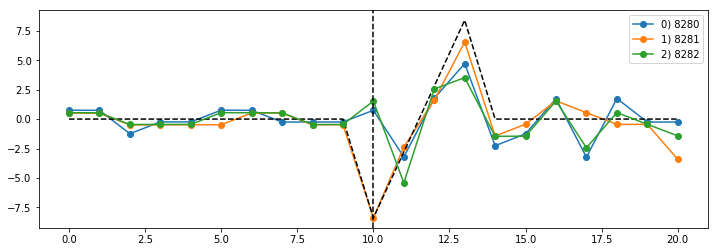

In [26]:
measid = 2760
px = 269640
w = 10

plot_sawtooth_example(measid, px, w)

# Preprocess

### Preprocess Train Data

In [27]:
%%time

if RECALCULATE_PEAK_FEATURES:

    train_df = pq.read_pandas(
        data_dir + '/train.parquet'
    ).to_pandas()
    
    train_fft = calculate_50hz_fourier_coefficient(train_df.values)
    
    train_peaks = process_measurement(
        train_df, 
        meta_train_df, 
        train_fft
    )

    del train_df, train_fft
    gc.collect()

CPU times: user 4min 48s, sys: 20.8 s, total: 5min 9s
Wall time: 4min 27s


In [28]:
if not RECALCULATE_PEAK_FEATURES:
    train_peaks = pd.read_pickle(PREPROCESSED_DIR + '/train_peaks.pkl')
    
train_peaks.to_pickle("train_peaks.pkl")

In [29]:
train_peaks = pd.merge(train_peaks, meta_train_df[['signal_id', 'id_measurement', 'target']], on='signal_id', how='left')

In [30]:
train_peaks.head()

,px,height,ratio_next,ratio_prev,small_dist_to_min,sawtooth_rmse,signal_id,phase_50hz,phase_aligned_x,Q,id_measurement,target
0,24554.0,4.705156,0.272445,0.902694,-1.0,0.080285,0,0.565718,133.462535,1,0,0
1,26087.0,5.568916,0.254407,0.785581,-1.0,0.081591,0,0.565718,134.152385,1,0,0
2,31681.0,8.415760,0.068728,0.891094,-1.0,0.075479,0,0.565718,136.669685,1,0,0
3,36913.0,6.569330,0.667703,0.816569,-1.0,0.099316,0,0.565718,139.024085,1,0,0
4,46340.0,5.765833,0.898712,0.897689,1.0,0.100638,0,0.565718,143.266235,1,0,0


In [31]:
train_peaks.shape

(1355697, 12)

### Preprocess Test Data

In [32]:
%%time

if RECALCULATE_PEAK_FEATURES:
    
    NUM_TEST_CHUNKS = 10
    
    test_chunk_size = int(np.ceil((meta_test_df.shape[0]/3.)/float(NUM_TEST_CHUNKS))*3.)
    
    test_peaks = []

    for j in range(NUM_TEST_CHUNKS):

        j_start = j*test_chunk_size
        j_end = (j+1)*test_chunk_size
        
        signal_ids = meta_test_df['signal_id'].values[j_start:j_end]

        test_df = pq.read_pandas(
            data_dir + '/test.parquet',
            columns=[str(c) for c in signal_ids]
        ).to_pandas()

        test_fft = calculate_50hz_fourier_coefficient(test_df.values)
        
        p = process_measurement(
            test_df, 
            meta_test_df.iloc[j_start:j_end], 
            test_fft
        )

        test_peaks.append(p)
        
        print(j)
        
        del test_df
        gc.collect()
        
    del test_fft
    gc.collect()
        
    test_peaks = pd.concat(test_peaks)
    
# Wall time: 9min 45s

0
1
2
3
4
5
6
7
8
9
CPU times: user 11min, sys: 24.5 s, total: 11min 24s
Wall time: 9min 56s


In [33]:
if not RECALCULATE_PEAK_FEATURES:
    test_peaks = pd.read_pickle(PREPROCESSED_DIR + '/test_peaks.pkl')
    
test_peaks.to_pickle("test_peaks.pkl")

In [34]:
test_peaks = pd.merge(test_peaks, meta_test_df[['signal_id', 'id_measurement']], on='signal_id', how='left')

In [35]:
test_peaks.head()

,px,height,ratio_next,ratio_prev,small_dist_to_min,sawtooth_rmse,signal_id,phase_50hz,phase_aligned_x,Q,id_measurement
0,626.0,7.781275,0.536742,0.917604,-1.0,0.078171,8712,-0.621068,54.697148,0,2904
1,6282.0,9.147859,0.741553,0.244895,1.0,0.092030,8712,-0.621068,57.242348,0,2904
2,11182.0,5.651763,0.761666,0.936194,-1.0,0.105641,8712,-0.621068,59.447348,0,2904
3,15652.0,4.134053,0.925795,0.042528,1.0,0.147892,8712,-0.621068,61.458848,0,2904
4,20522.0,9.759927,0.734398,0.731715,1.0,0.082194,8712,-0.621068,63.650348,0,2904


In [36]:
test_peaks.tail()

,px,height,ratio_next,ratio_prev,small_dist_to_min,sawtooth_rmse,signal_id,phase_50hz,phase_aligned_x,Q,id_measurement
2682253,727037.0,4.986428,0.592922,0.609012,4.0,0.124790,29048,0.011103,57.802808,0,9682
2682254,733881.0,5.829542,0.028948,0.323941,5.0,0.152432,29048,0.011103,60.882608,0,9682
2682255,749916.0,6.024067,0.489067,0.014096,2.0,0.101373,29048,0.011103,68.098358,0,9682
2682256,769000.0,6.529602,0.080297,0.980832,-1.0,0.111408,29048,0.011103,76.686158,0,9682
2682257,789727.0,7.474286,0.466995,0.073557,1.0,0.107305,29048,0.011103,86.013308,0,9682


In [37]:
meta_test_df.shape

(20337, 3)

In [38]:
test_peaks.shape

(2682258, 11)

# Features

In [39]:
def save_importances(importances_, filename='importances.png', print_results=False, figsize=(8, 6)):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    if print_results:
        display(HTML(mean_gain.sort_values('gain').to_html()))
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=figsize)
    sns.barplot(x='gain', y='feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    plt.savefig(filename)

In [40]:
def process(peaks_df, meta_df, use_improved=True):

    results = pd.DataFrame(index=meta_df['id_measurement'].unique())
    results.index.rename('id_measurement', inplace=True)
    
    ################################################################################
    
    if not USE_SIMPLIFIED_VERSION:
        # Filter peaks using ratio_next and height features
        # Note: may not be all that important
        peaks_df = peaks_df[~(
            (peaks_df['ratio_next'] > 0.33333)
            & (peaks_df['height'] > 50)
        )]
    
    ################################################################################

    # Count peaks in phase resolved quarters 0 and 2
    p = peaks_df[peaks_df['Q'].isin([0, 2])].copy()
    res = p.groupby('id_measurement').agg(
    {
        'px': ['count'],
    })
    res.columns = ["peak_count_Q02"]
    results = pd.merge(results, res, on='id_measurement', how='left')
        
    ################################################################################
    
    # Count total peaks for each measurement id
    res = peaks_df.groupby('id_measurement').agg(
    {
        'px': ['count'],
    })
    res.columns = ["peak_count_total"]
    results = pd.merge(results, res, on='id_measurement', how='left')

    ################################################################################

    # Count peaks in phase resolved quarters 1 and 3
    p = peaks_df[peaks_df['Q'].isin([1, 3])].copy()
    res = p.groupby('id_measurement').agg(
    {
        'px': ['count'],
    })
    res.columns = ['peak_count_Q13']
    results = pd.merge(results, res, on='id_measurement', how='left')
    
    ################################################################################
    
    # Calculate additional features using phase resolved quarters 0 and 2
    
    feature_quarters = [0, 2]
    
    p = peaks_df[peaks_df['Q'].isin(feature_quarters)].copy()
    
    p['abs_small_dist_to_min'] = np.abs(p['small_dist_to_min'])
    
    res = p.groupby('id_measurement').agg(
    {
        
        'height': ['mean', 'std'],
        'ratio_prev': ['mean'],
        'ratio_next': ['mean'],
        'abs_small_dist_to_min': ['mean'],        
        'sawtooth_rmse': ['mean'],
    })
    res.columns = ["_".join(f) + '_Q02' for f in res.columns]     
    results = pd.merge(results, res, on='id_measurement', how='left')
        
    return results

In [41]:
def create_features(
    meta_df, 
    peaks_df,
):
    
    res = process(peaks_df, meta_df)
    
    return res

### Create Train features

In [42]:
%%time
X_train_full = create_features( 
    meta_train_df, 
    train_peaks,
)

CPU times: user 576 ms, sys: 328 ms, total: 904 ms
Wall time: 908 ms


In [43]:
y_train = (
    meta_train_df.groupby('id_measurement')['target'].sum().round(0).astype(np.int)
    != 0
).astype(np.float)

assert np.all(y_train.index.values == X_train_full.index.values)

In [44]:
X_train_full.head(6)

,peak_count_Q02,peak_count_total,peak_count_Q13,height_mean_Q02,height_std_Q02,ratio_prev_mean_Q02,ratio_next_mean_Q02,abs_small_dist_to_min_mean_Q02,sawtooth_rmse_mean_Q02
id_measurement,,,,,,,,,
0,165,436,271,7.550990,4.107265,0.364844,0.420357,1.806061,0.078942
1,240,588,348,8.642092,6.107522,0.370418,0.402447,1.845833,0.070900
2,54,108,54,9.975210,7.311196,0.271753,0.329117,2.055556,0.108161
3,326,681,355,13.370676,11.202168,0.485182,0.454746,2.368098,0.165865
4,229,470,241,8.666442,7.412242,0.395006,0.522988,2.144105,0.092497
5,62,118,56,7.926053,4.553996,0.479266,0.483325,1.790323,0.093777


In [45]:
y_train.head(6)

id_measurement
0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: target, dtype: float64

In [46]:
y_train.sum()

194.0

In [47]:
X_train_full.shape, y_train.shape

((2904, 9), (2904,))

### Create Test Features

In [48]:
%%time
X_test_full = create_features( 
    meta_test_df, 
    test_peaks,
)

CPU times: user 1.12 s, sys: 904 ms, total: 2.02 s
Wall time: 2.02 s


In [49]:
X_test_full.head()

,peak_count_Q02,peak_count_total,peak_count_Q13,height_mean_Q02,height_std_Q02,ratio_prev_mean_Q02,ratio_next_mean_Q02,abs_small_dist_to_min_mean_Q02,sawtooth_rmse_mean_Q02
id_measurement,,,,,,,,,
2904,226,522,296,7.402824,4.015168,0.437531,0.543964,1.522124,0.078465
2905,39,80,41,6.564506,0.193209,0.402385,0.443438,5.000000,0.162205
2906,33,92,59,8.170872,1.212187,0.568340,0.623352,3.787879,0.180245
2907,77,175,98,6.781182,3.530254,0.317405,0.436253,2.207792,0.102017
2908,44,77,33,5.341713,0.664465,0.724390,0.826892,4.272727,0.257187


In [50]:
X_test_full.tail()

,peak_count_Q02,peak_count_total,peak_count_Q13,height_mean_Q02,height_std_Q02,ratio_prev_mean_Q02,ratio_next_mean_Q02,abs_small_dist_to_min_mean_Q02,sawtooth_rmse_mean_Q02
id_measurement,,,,,,,,,
9678,290,705,415,8.398039,3.965574,0.461735,0.507951,1.610345,0.076102
9679,1133,1664,531,19.232775,17.955258,0.358900,0.364797,2.857899,0.184237
9680,38,79,41,7.276918,2.176912,0.640917,0.612123,3.763158,0.156102
9681,210,389,179,5.757246,3.445757,0.461069,0.576428,1.533333,0.081011
9682,42,103,61,5.940924,1.522449,0.481581,0.486717,3.190476,0.124039


# Drop Features

In [51]:
default_features_to_drop = [
    'id_measurement',
    'phase',
    'fft_phase',
    'signal_id',
]

In [52]:
if USE_SIMPLIFIED_VERSION:
    additional_features_to_drop = [
        #'peak_count_Q13',
        'abs_small_dist_to_min_mean_Q02',
        'height_mean_Q02',
        #'height_std_Q02',
        #'sawtooth_rmse_mean_Q02',
        #'peak_count_Q02',
        'ratio_next_mean_Q02',
        'ratio_prev_mean_Q02',
        #'peak_count_total' 
    ]
else:
    additional_features_to_drop = []

In [53]:
features_to_drop = (
    default_features_to_drop
    + additional_features_to_drop 
)

In [54]:
if USE_SIMPLIFIED_VERSION:
    feature_names = sorted([c for c in X_train_full.columns if c not in features_to_drop])
else:
    # to maintain consistent order with original version after feature renaming
    feature_names = [
        'peak_count_Q13',
        'abs_small_dist_to_min_mean_Q02',
        'height_mean_Q02',
        'height_std_Q02',
        'sawtooth_rmse_mean_Q02',
        'peak_count_Q02',
        'ratio_next_mean_Q02',
        'ratio_prev_mean_Q02',
        'peak_count_total'   
    ]

In [55]:
X_train = X_train_full[feature_names]
X_test = X_test_full[feature_names]

In [56]:
X_train.head(6)

,peak_count_Q13,abs_small_dist_to_min_mean_Q02,height_mean_Q02,height_std_Q02,sawtooth_rmse_mean_Q02,peak_count_Q02,ratio_next_mean_Q02,ratio_prev_mean_Q02,peak_count_total
id_measurement,,,,,,,,,
0,271,1.806061,7.550990,4.107265,0.078942,165,0.420357,0.364844,436
1,348,1.845833,8.642092,6.107522,0.070900,240,0.402447,0.370418,588
2,54,2.055556,9.975210,7.311196,0.108161,54,0.329117,0.271753,108
3,355,2.368098,13.370676,11.202168,0.165865,326,0.454746,0.485182,681
4,241,2.144105,8.666442,7.412242,0.092497,229,0.522988,0.395006,470
5,56,1.790323,7.926053,4.553996,0.093777,62,0.483325,0.479266,118


In [57]:
X_train.shape

(2904, 9)

In [58]:
feature_names

['peak_count_Q13',
 'abs_small_dist_to_min_mean_Q02',
 'height_mean_Q02',
 'height_std_Q02',
 'sawtooth_rmse_mean_Q02',
 'peak_count_Q02',
 'ratio_next_mean_Q02',
 'ratio_prev_mean_Q02',
 'peak_count_total']

# Training Code

In [59]:
@numba.jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

#@numba.jit
def eval_mcc(y_true, y_prob, show=False):
    """
    A fast implementation of Anokas mcc optimization code.

    This code takes as input probabilities, and selects the threshold that 
    yields the best MCC score. It is efficient enough to be used as a 
    custom evaluation function in xgboost
    
    Source: https://www.kaggle.com/cpmpml/optimizing-probabilities-for-best-mcc
    Source: https://www.kaggle.com/c/bosch-production-line-performance/forums/t/22917/optimising-probabilities-binary-prediction-script
    Creator: CPMP
    """
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_proba,  best_mcc, None

In [60]:
def train(
    X_data, 
    y_data,
    params,
    feature_names, 
    verbose_eval=50,
    kfold_random_state=23948,
    predict=False,
    calculate_mcc=False,
    early_stopping_rounds=10,
    num_folds=5,
    num_iterations=10,
):
    
    params = copy.deepcopy(params)
    
    models = []
    cv_scores = []
    val_cv_scores = []
    if calculate_mcc:
        mcc_scores = []
        val_mcc_scores = []
        thresholds=[]
    else:
        mcc_scores = None
        val_mcc_scores = None
        thresholds = None
        
    if predict:
        yp_train = np.zeros(X_train.shape[0])
        yp_val = np.zeros(X_train.shape[0])
        yp_test = np.zeros(X_train.shape[0])
    else:
        yp_train = None
        yp_val = None
        yp_test = None
        
    for iter in range(num_iterations):
        
        np.random.seed(kfold_random_state + iter)
        splits = np.zeros(X_data.shape[0], dtype=np.int)
        m = y_data == 1
        splits[m] = np.random.randint(0, 5, size=m.sum())
        m = y_data == 0
        splits[m] = np.random.randint(0, 5, size=m.sum())

        for fold in range(num_folds):

            val_fold = fold
            test_fold = (fold + 1) % num_folds

            train_folds = [f for f in range(num_folds) if f not in [val_fold, test_fold]]

            train_indices = np.where(np.isin(splits, train_folds))[0]
            val_indices = np.where(splits == val_fold)[0]
            test_indices = np.where(splits == test_fold)[0]

            trn = lgb.Dataset(
                X_data.values[train_indices],
                y_data[train_indices],
                feature_name=feature_names,
            )

            val = lgb.Dataset(
                X_data.values[val_indices],
                y_data[val_indices],
                feature_name=feature_names,
            )

            test = lgb.Dataset(
                X_data.values[test_indices],
                y_data[test_indices],
                feature_name=feature_names,
            )

            # train model

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = lgb.train(
                    params, 
                    trn, 
                    #num_boost_round=10000, 
                    valid_sets=(trn, test, val), 
                    valid_names=("train", "test", "validation"), 
                    fobj=None, 
                    feval=None,
                    early_stopping_rounds=early_stopping_rounds,
                    #evals_result=training_data,
                    verbose_eval=verbose_eval,
                )


            yp = None

            if predict:
                yp = model.predict(X_train.values[train_indices])
                yp_train[train_indices] += yp

                yp_val_fold = model.predict(X_train.values[val_indices])
                yp_val[val_indices] += yp_val_fold
                
                yp_test_fold = model.predict(X_train.values[test_indices])
                yp_test[test_indices] += yp_test_fold

            models.append(model)

            s = model.best_score['test']
            cv_scores.append(s[list(s.keys())[0]])

            s = model.best_score['validation']
            val_cv_scores.append(s[list(s.keys())[0]])

            if calculate_mcc:

                # find optimal probability threshold using training data
                best_proba, _, _ = eval_mcc(
                    y_train.values[train_indices].astype(np.float),
                    yp, 
                    False
                )

                # calculate validation MCC score using optimal probability threshold
                best_mcc_val = matthews_corrcoef(
                    y_train.values[val_indices].astype(np.float), 
                    yp_val_fold.astype(np.float) > best_proba
                )

                # calculate test MCC score using optimal probability threshold
                best_mcc = matthews_corrcoef(
                    y_train.values[test_indices].astype(np.float), 
                    yp_test_fold.astype(np.float) > best_proba
                )

                val_mcc_scores.append(best_mcc_val)
                mcc_scores.append(best_mcc)
                thresholds.append(best_proba)

    if yp_train is not None:
        yp_train /= ((num_folds - 2) * num_iterations)
        yp_val /= num_iterations
        yp_test /= num_iterations
            
    cv_scores = np.array(cv_scores)
    val_cv_scores = np.array(val_cv_scores)
    if calculate_mcc:
        mcc_scores = np.array(mcc_scores)
        val_mcc_scores = np.array(val_mcc_scores)
        thresholds = np.array(thresholds)
        
    return (
        models,
        cv_scores, val_cv_scores, 
        mcc_scores, val_mcc_scores, 
        yp_train, yp_val, yp_test, thresholds
    )

# Train

In [61]:
params = {
    'objective': 'binary',
    #'is_unbalance': True,
    'boosting': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 80, # 61,
    'num_threads': 4,
    'metric': 'binary_logloss',
    'feature_fraction': 0.8,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'seed': 23974,
    'num_boost_round': 10000,
}

In [62]:
%%time

(
    models,
    cv_scores, val_cv_scores, 
    mcc_scores, val_mcc_scores, 
    yp_train, yp_val, yp_test, thresholds
) = train(
    X_train, 
    y_train,
    params,
    feature_names, 
    verbose_eval=0, # 50,
    kfold_random_state=123948,
    predict=True,
    calculate_mcc=True,
    early_stopping_rounds=100,
    num_iterations=25 # 100
)

print("")
print("CV Logloss: {:.4f} +/- {:.4f} ({:.4f})".format(cv_scores.mean(), cv_scores.std()/np.sqrt(cv_scores.shape[0]), cv_scores.std()))
print("CV Val Logloss: {:.4f} +/- {:.4f} ({:.4f})".format(val_cv_scores.mean(), val_cv_scores.std()/np.sqrt(val_cv_scores.shape[0]), val_cv_scores.std()))
print("CV MCC: {:.4f} +/- {:.4f} ({:.4f})".format(mcc_scores.mean(), mcc_scores.std()/np.sqrt(mcc_scores.shape[0]), mcc_scores.std()))
print("CV VAL MCC: {:.4f} +/- {:.4f} ({:.4f})".format(val_mcc_scores.mean(), val_mcc_scores.std()/np.sqrt(val_mcc_scores.shape[0]), val_mcc_scores.std()))
print("Threshold {:.4f} +/- {:.4f}".format(thresholds.mean(), thresholds.std()/np.sqrt(thresholds.shape[0])))

##################################

best_proba_meas, _, _ = eval_mcc(
    y_train.values.astype(np.float),
    yp_train, 
    False
)

best_mcc_meas = matthews_corrcoef(
    y_train.values.astype(np.float), 
    yp_val > best_proba_meas
)

best_mcc_meas_test = matthews_corrcoef(
    y_train.values.astype(np.float), 
    yp_test > best_proba_meas
)

plt.show()

##################################

yp_train_df = pd.DataFrame(
    yp_train,
    index=X_train_full.index
)

yp_val_df = pd.DataFrame(
    yp_val,
    index=X_train_full.index
)

yp_test_df = pd.DataFrame(
    yp_test,
    index=X_train_full.index
)

train_pred = meta_train_df[['id_measurement', 'signal_id', 'target']].copy()
train_pred = pd.merge(train_pred, yp_train_df, on='id_measurement')
train_pred.rename({0:'prediction'}, axis=1, inplace=True)

val_pred = meta_train_df[['id_measurement', 'signal_id', 'target']].copy()
val_pred = pd.merge(val_pred, yp_val_df, on='id_measurement')
val_pred.rename({0:'prediction'}, axis=1, inplace=True)

test_pred = meta_train_df[['id_measurement', 'signal_id', 'target']].copy()
test_pred = pd.merge(test_pred, yp_test_df, on='id_measurement')
test_pred.rename({0:'prediction'}, axis=1, inplace=True)

best_proba, _, _ = eval_mcc(
    train_pred['target'].values.astype(np.float),
    train_pred['prediction'].values.astype(np.float),
    False
)

best_mcc = matthews_corrcoef(
    val_pred['target'].values.astype(np.float), 
    val_pred['prediction'].values.astype(np.float) > best_proba
)

best_mcc_test = matthews_corrcoef(
    test_pred['target'].values.astype(np.float), 
    test_pred['prediction'].values.astype(np.float) > best_proba
)

##################################

plt.show()

print("MCC (measurement): {:.3f}".format(best_mcc_meas))
print("MCC Test (measurement): {:.3f}".format(best_mcc_meas_test))
print("Best Probability Threshold(measurement): {:.3f}".format(best_proba_meas))

print("MCC: {:.3f}".format(best_mcc))
print("MCC Test: {:.3f}".format(best_mcc_test))
print("Best Probability Threshold: {:.3f}".format(best_proba))


CV Logloss: 0.0985 +/- 0.0014 (0.0158)
CV Val Logloss: 0.0986 +/- 0.0014 (0.0157)
CV MCC: 0.7124 +/- 0.0050 (0.0562)
CV VAL MCC: 0.7129 +/- 0.0052 (0.0580)
Threshold 0.3502 +/- 0.0045
MCC (measurement): 0.738
MCC Test (measurement): 0.746
Best Probability Threshold(measurement): 0.355
MCC: 0.720
MCC Test: 0.729
Best Probability Threshold: 0.380
CPU times: user 9min 48s, sys: 16.9 s, total: 10min 5s
Wall time: 2min 45s


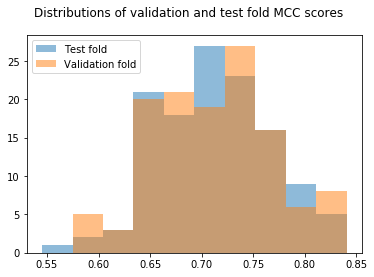

In [63]:
_, bins, _ = plt.hist(mcc_scores, alpha=0.5, label='Test fold')
plt.hist(val_mcc_scores, alpha=0.5, bins=bins, label='Validation fold')
plt.legend()
plt.suptitle("Distributions of validation and test fold MCC scores")
plt.show()

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


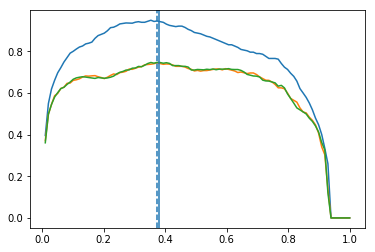

0.7445676389184409 0.37373737373737376


In [64]:
thresholds = np.linspace(0, 1, 100)[1:]

scores_train = []
scores_val = []
scores_test = []

for t in thresholds:
    
    s_train = matthews_corrcoef(
        y_train.values.astype(np.float), 
        yp_train > t
    )
    
    s_val = matthews_corrcoef(
        y_train.values.astype(np.float), 
        yp_val > t
    )
    
    s_test = matthews_corrcoef(
        y_train.values.astype(np.float), 
        yp_test > t
    )
    
    scores_train.append(s_train)
    scores_val.append(s_val)
    scores_test.append(s_test)
    
plt.plot(thresholds, scores_train)
plt.plot(thresholds, scores_val)
plt.plot(thresholds, scores_test)
plt.axvline(best_proba)
plt.axvline(thresholds[np.argmax(scores_val)], ls='--')
plt.show()

print(np.max(scores_val), thresholds[np.argmax(scores_val)])

In [65]:
train_pred['probability_thresholded'] = (train_pred['prediction'] > best_proba).astype(np.int)

In [66]:
train_pred.head()

,id_measurement,signal_id,target,prediction,probability_thresholded
0,0,0,0,0.097050,0
1,0,1,0,0.097050,0
2,0,2,0,0.097050,0
3,1,3,1,0.673375,1
4,1,4,1,0.673375,1


In [67]:
train_pred.to_csv('train_results.csv', index=False)

# Analysis

## Feature Importance

In [68]:
importances = pd.DataFrame()

for fold_ in range(len(models)):
    
    model = models[fold_]
    
    imp_df = pd.DataFrame()
    imp_df['feature'] = X_train.columns
    imp_df['gain'] = model.feature_importance('gain')
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

,gain
feature,
ratio_prev_mean_Q02,1114.540225
ratio_next_mean_Q02,1166.367412
height_mean_Q02,1395.669880
abs_small_dist_to_min_mean_Q02,1728.949063
peak_count_Q02,2076.505274
height_std_Q02,2170.050398
peak_count_total,3027.933942
peak_count_Q13,5581.206631
sawtooth_rmse_mean_Q02,12318.886978


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


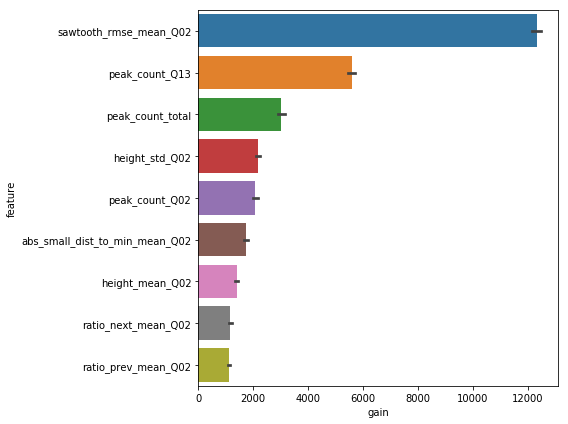

In [69]:
save_importances(importances_=importances, print_results=True)

## Prediction Errors

In [70]:
prediction_errors = y_train.copy().to_frame()
prediction_errors.columns = ['target']
prediction_errors['error'] = np.abs(y_train.values - yp_train)

prediction_errors = prediction_errors.sort_values('error')

In [71]:
prediction_errors.head(10)

,target,error
id_measurement,,
1380,0.0,0.004017
2718,0.0,0.004069
2499,0.0,0.004094
2723,0.0,0.004114
244,0.0,0.004118
386,0.0,0.004124
1530,0.0,0.004125
65,0.0,0.004127
2074,0.0,0.004134


In [72]:
prediction_errors.tail(10)

,target,error
id_measurement,,
41,0.0,0.617842
1256,1.0,0.618366
90,1.0,0.620212
145,1.0,0.635863
1624,1.0,0.638048
126,1.0,0.645305
1103,1.0,0.686100
1010,1.0,0.708625
1981,1.0,0.721519


In [73]:
prediction_errors[prediction_errors['target'] == 0].tail(10)

,target,error
id_measurement,,
2348,0.0,0.441113
1424,0.0,0.446730
1549,0.0,0.454828
2090,0.0,0.457131
1798,0.0,0.465472
2060,0.0,0.506925
2823,0.0,0.510058
1477,0.0,0.515470
1637,0.0,0.578635


# Test

In [74]:
X_test.head()

,peak_count_Q13,abs_small_dist_to_min_mean_Q02,height_mean_Q02,height_std_Q02,sawtooth_rmse_mean_Q02,peak_count_Q02,ratio_next_mean_Q02,ratio_prev_mean_Q02,peak_count_total
id_measurement,,,,,,,,,
2904,296,1.522124,7.402824,4.015168,0.078465,226,0.543964,0.437531,522
2905,41,5.000000,6.564506,0.193209,0.162205,39,0.443438,0.402385,80
2906,59,3.787879,8.170872,1.212187,0.180245,33,0.623352,0.568340,92
2907,98,2.207792,6.781182,3.530254,0.102017,77,0.436253,0.317405,175
2908,33,4.272727,5.341713,0.664465,0.257187,44,0.826892,0.724390,77


In [75]:
X_test.shape, meta_test_df.shape

((6779, 9), (20337, 3))

In [76]:
len(models)

125

In [77]:
%%time

yp_test = np.zeros(X_test.shape[0])

for j in range(len(models)):
    
    model = models[j]

    yp_test += model.predict(X_test.values)/len(models)

CPU times: user 38.2 s, sys: 24 ms, total: 38.3 s
Wall time: 9.71 s


In [78]:
test_submission = pd.DataFrame(
    yp_test,
    index=X_test.index,
    columns=['probability']
)

In [79]:
test_submission['probability_thresholded'] = (yp_test > best_proba).astype(np.int)

In [80]:
test_submission = pd.merge(
    meta_test_df[['id_measurement', 'signal_id']],
    test_submission,
    on='id_measurement',
    how='left'
)

In [81]:
test_submission['probability_thresholded'].sum()

780

In [82]:
test_submission.head()

,id_measurement,signal_id,probability,probability_thresholded
0,2904,8712,0.076275,0
1,2904,8713,0.076275,0
2,2904,8714,0.076275,0
3,2905,8715,0.004499,0
4,2905,8716,0.004499,0


In [83]:
test_submission.tail()

,id_measurement,signal_id,probability,probability_thresholded
20332,9681,29044,0.031788,0
20333,9681,29045,0.031788,0
20334,9682,29046,0.004525,0
20335,9682,29047,0.004525,0
20336,9682,29048,0.004525,0


In [84]:
test_submission.to_csv('test_results.csv', index=False)

In [85]:
submission = pd.read_csv(data_dir + '/sample_submission.csv')

In [86]:
assert np.all(submission['signal_id'].values == test_submission['signal_id'].values)

submission['target'] = test_submission['probability_thresholded'].values

In [87]:
submission.shape, X_test.shape[0]*3

((20337, 2), 20337)

In [88]:
submission.head()

,signal_id,target
0,8712,0
1,8713,0
2,8714,0
3,8715,0
4,8716,0


In [89]:
submission.to_csv('submission.csv', index=False)

In [90]:
!head submission.csv

signal_id,target
8712,0
8713,0
8714,0
8715,0
8716,0
8717,0
8718,0
8719,0
8720,0


# Analysis

### Proportions of train and test data detected as faulty

In [91]:
submission['target'].sum()

780

In [92]:
meta_train_df['target'].mean(), (yp_train > best_proba).astype(np.float).mean(), submission['target'].mean()

(0.060261707988980714, 0.06818181818181818, 0.03835373948960023)

In [93]:
(meta_train_df['target'].values.reshape(-1, 3).sum(axis=1) > 0).mean()

0.06680440771349862

In [94]:
(submission['target'].values.reshape(-1, 3).sum(axis=1) > 0).mean()

0.03835373948960023

## Important Features Partial Plots

In [95]:
X_train_full.head()

,peak_count_Q02,peak_count_total,peak_count_Q13,height_mean_Q02,height_std_Q02,ratio_prev_mean_Q02,ratio_next_mean_Q02,abs_small_dist_to_min_mean_Q02,sawtooth_rmse_mean_Q02
id_measurement,,,,,,,,,
0,165,436,271,7.550990,4.107265,0.364844,0.420357,1.806061,0.078942
1,240,588,348,8.642092,6.107522,0.370418,0.402447,1.845833,0.070900
2,54,108,54,9.975210,7.311196,0.271753,0.329117,2.055556,0.108161
3,326,681,355,13.370676,11.202168,0.485182,0.454746,2.368098,0.165865
4,229,470,241,8.666442,7.412242,0.395006,0.522988,2.144105,0.092497


In [96]:
y_train.head()

id_measurement
0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: target, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


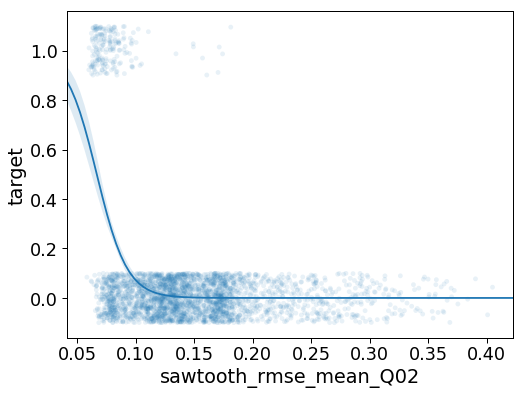

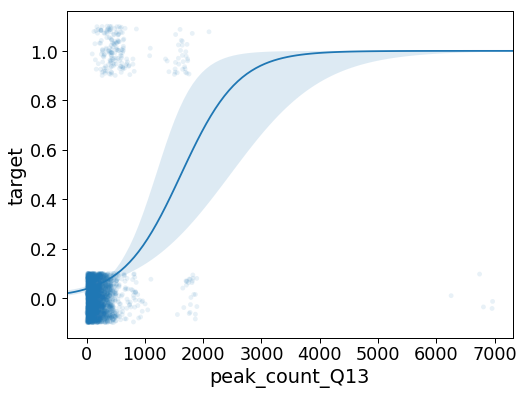

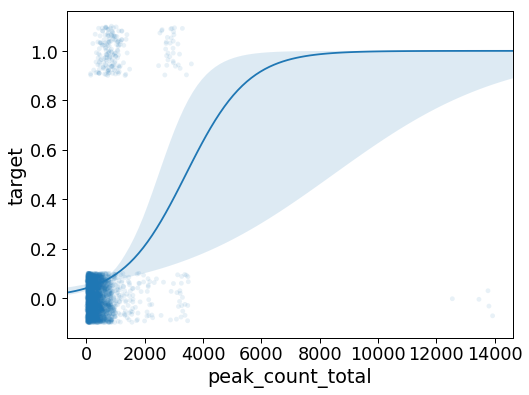

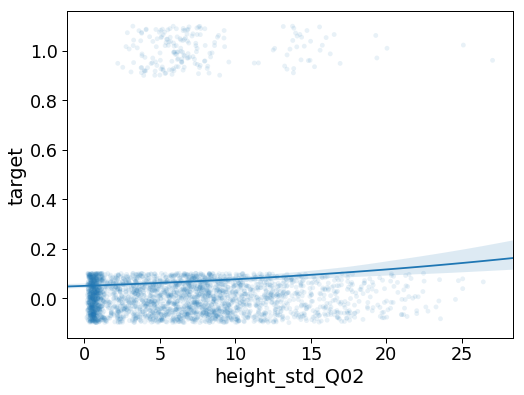

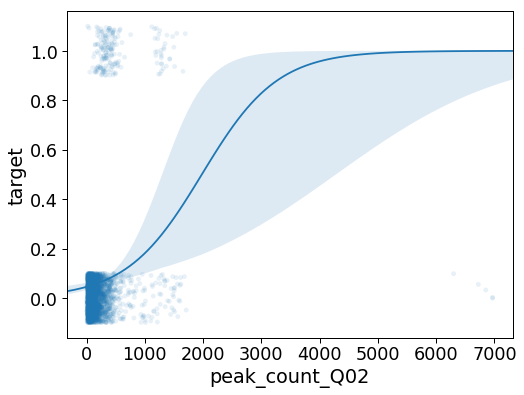

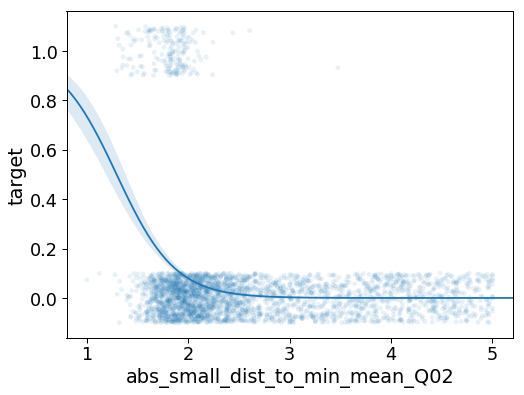

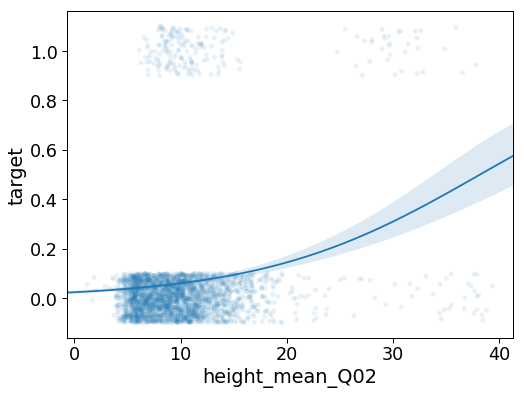

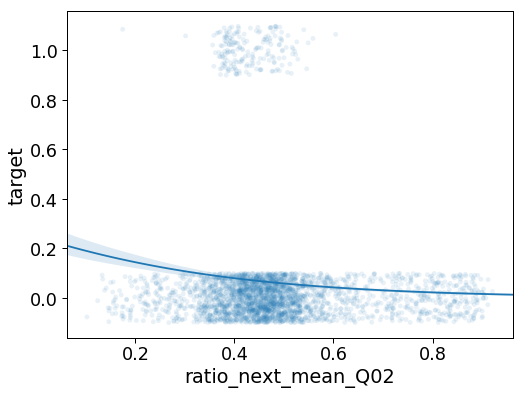

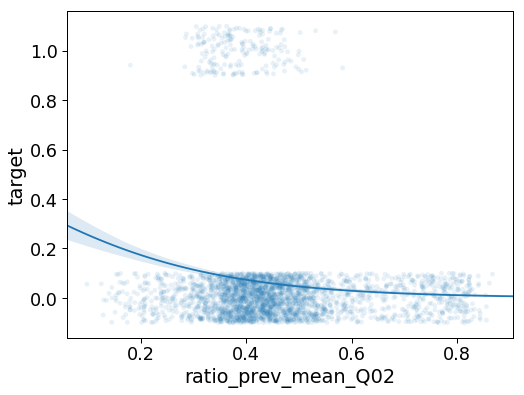

In [97]:
sns.set_context("paper", font_scale=2)

important_features = importances[['gain', 'feature']].groupby('feature').mean().sort_values('gain').index.values[::-1]

for f in important_features:
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    sns.regplot(
        f,
        'target',
        pd.merge(X_train, y_train.to_frame(), on='id_measurement', how='left'),
        logistic=True,
        n_boot=100,
        y_jitter=.1,
        scatter_kws={'alpha':0.1, 'edgecolor':'none'},
        ax=ax
    )
    plt.show()
    #break

# Save Models

In [98]:
for j in range(len(models)):
    models[j].save_model('model_{}.txt'.format(j))

In [99]:
!head model_0.txt

tree
version=v2
num_class=1
num_tree_per_iteration=1
label_index=0
max_feature_idx=8
objective=binary sigmoid:1
feature_names=peak_count_Q13 abs_small_dist_to_min_mean_Q02 height_mean_Q02 height_std_Q02 sawtooth_rmse_mean_Q02 peak_count_Q02 ratio_next_mean_Q02 ratio_prev_mean_Q02 peak_count_total
feature_infos=[5:6962] [1:5] [1.1833948938784753:39.363600654220612] [0.18583604489239919:27.042694539610125] [0.058286659397966359:0.40090030586061143] [5:6970] [0.13393881567134042:0.91159961794154909] [0.12557928274436592:0.85533899350981857] [12:13932]
tree_sizes=1746 2669 2750 3124 2835 3434 3534 3704 4095 3758 3768 3537 4102 3774 3790 3544 3873 4008 4155 3709 4149 4315 4406 4499 4729 4431 4338 4227 4418 4492 4486 4345 4578 4589 4635 4325 4415 4229 4491 4268 4418 4339 4207 4396 4431 4246 4665 4400 4583 4338 4343 4565 4277 4392 4359 4108 4321 4487 4330 4319 4479 4474 4347 4581 4413 4580 4588 4261 4484 4500 4168 4319 4579 4585 4266 4492 4255 4565 4418 4467 4185 4496 4108 4654 4494 4323 4416